In [ ]:
# !pip3 install nltk

In [1]:
from surprise import SVD
import numpy as np
import surprise
import ast
from ast import literal_eval
import pandas as pd
import seaborn as sns
from surprise import SVD, Dataset, Reader
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise.model_selection import train_test_split, cross_validate
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise.model_selection import cross_validate

In [ ]:
#Building a Matrix Factorization model

In [2]:
movie_data=pd.read_csv("archive/movies_metadata.csv")

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1187500383.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_data=pd.read_csv("archive/movies_metadata.csv")


In [3]:
ratings_data=pd.read_csv("archive/ratings_small.csv")

In [4]:
print(movie_data.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [5]:
print(movie_data.shape)
print(movie_data.columns)
print(movie_data.head(1))

(45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   

                               homepage   id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story  862  tt0114709                en   

  original_title                                           overview  ...  \
0      Toy Story  Led by Woody, Andy's toys live happily in his ...  ...   

  release_date   

(100004, 4)
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


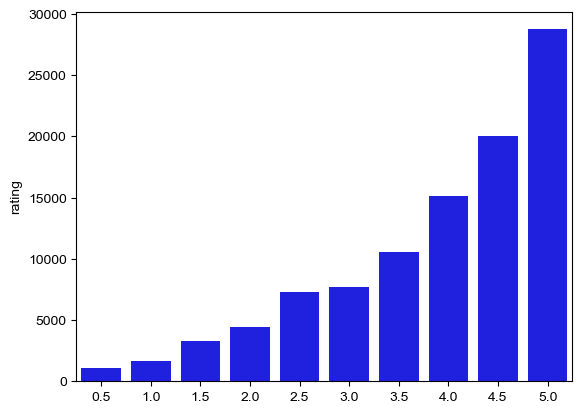

In [6]:
print(ratings_data.shape)
print(ratings_data.columns)
rankings_count = ratings_data.rating.value_counts().sort_values()
sns.barplot(x=rankings_count.index.sort_values(), y=rankings_count, color="b")
sns.set_theme(style="whitegrid")

In [7]:
print(movie_data.shape)

(45466, 24)


In [8]:
print(movie_data.isna().sum())

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64


In [9]:
print(movie_data['popularity'])

0        21.946943
1        17.015539
2          11.7129
3         3.859495
4         8.387519
           ...    
45461     0.072051
45462     0.178241
45463     0.903007
45464     0.003503
45465     0.163015
Name: popularity, Length: 45466, dtype: object


In [10]:
movie_data['genres'] = movie_data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [11]:
print(movie_data['genres'].head())

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object


In [12]:
print(movie_data['vote_average'])

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
45461    4.0
45462    9.0
45463    3.8
45464    0.0
45465    0.0
Name: vote_average, Length: 45466, dtype: float64


In [ ]:
# I will use IMDB's weighted rating formula to construct my chart. 
# WR = (v.R)/(v+m)+(m.C)/(v+m)
# C --> mean of all vote averages
# m --> minimum number of votes to add in chart

In [13]:
vote_counts = movie_data[movie_data['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movie_data[movie_data['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
print(C)

5.244896612406511


In [14]:
m = vote_counts.quantile(0.95)
#This means 95% of the movies has less than m votes.

In [15]:
print(f"The minimum value of votes so that we can add in chart are {m}")

The minimum value of votes so that we can add in chart are 434.0


In [16]:
#Extracting the year.
movie_data['year'] = pd.to_datetime(movie_data['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [17]:
print(movie_data['year'].head())

0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object


In [18]:
movie_data_preprocessed = movie_data[(movie_data['vote_count'] >= m) & (movie_data['vote_count'].notnull()) & (movie_data['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
movie_data_preprocessed['vote_count'] = movie_data_preprocessed['vote_count'].astype('int')
movie_data_preprocessed['vote_average'] = movie_data_preprocessed['vote_average'].astype('int')
print(movie_data_preprocessed.shape)
print(movie_data_preprocessed.head())

(2274, 6)
        title  year  vote_count  vote_average popularity  \
0   Toy Story  1995        5415             7  21.946943   
1     Jumanji  1995        2413             6  17.015539   
5        Heat  1995        1886             7  17.924927   
9   GoldenEye  1995        1194             6  14.686036   
15     Casino  1995        1343             7  10.137389   

                              genres  
0        [Animation, Comedy, Family]  
1       [Adventure, Fantasy, Family]  
5   [Action, Crime, Drama, Thriller]  
9      [Adventure, Action, Thriller]  
15                    [Drama, Crime]  


In [19]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [21]:
movie_data_preprocessed['wr'] = movie_data_preprocessed.apply(weighted_rating, axis=1)

In [22]:
movie_data_preprocessed_top_movies = movie_data_preprocessed.sort_values('wr', ascending=False).head(250)

In [23]:
print("These are the top movies according to the weighted rating")
print(movie_data_preprocessed_top_movies)

These are the top movies according to the weighted rating
                                                   title  year  vote_count  \
15480                                          Inception  2010       14075   
12481                                    The Dark Knight  2008       12269   
22879                                       Interstellar  2014       11187   
2843                                          Fight Club  1999        9678   
4863   The Lord of the Rings: The Fellowship of the Ring  2001        8892   
...                                                  ...   ...         ...   
2006                Indiana Jones and the Temple of Doom  1984        2841   
16129                                  The King's Speech  2010        2817   
895                                     Sunset Boulevard  1950         533   
9888                                            Sin City  2005        2755   
16833                                        Source Code  2011        2752   

     

In [24]:
s = movie_data_preprocessed.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
print(s)

0              Animation
0                 Comedy
0                 Family
1              Adventure
1                Fantasy
              ...       
45014             Action
45014            Western
45014    Science Fiction
45014            Fantasy
45014             Horror
Name: genre, Length: 6261, dtype: object


In [25]:
gen_movie_data = movie_data.drop('genres', axis=1).join(s)
print(gen_movie_data)

       adult                              belongs_to_collection    budget  \
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      False                                                NaN  65000000   
1      False                                                NaN  65000000   
...      ...                                                ...       ...   
45461  False                                                NaN         0   
45462  False                                                NaN         0   
45463  False                                                NaN         0   
45464  False                                                NaN         0   
45465  False                                                NaN         0   

                                   homepage      id    imdb_id  \
0      ht

In [26]:
def build_chart(genre, percentile=0.85):
    df = gen_movie_data[gen_movie_data['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    movie_data_top_genre = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    movie_data_top_genre['vote_count'] = movie_data_top_genre['vote_count'].astype('int')
    movie_data_top_genre['vote_average'] = movie_data_top_genre['vote_average'].astype('int')
    
    movie_data_top_genre['wr'] = movie_data_top_genre.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    movie_data_top_genre = movie_data_top_genre.sort_values('wr', ascending=False).head(250)
    
    return movie_data_top_genre

In [27]:
print("These are the top Romance movies:")
build_chart('Romance').head(15)

These are the top Romance movies:


,title,year,vote_count,vote_average,popularity,wr
351,Forrest Gump,1994,8147,8,48.307194,7.666317
1639,Titanic,1997,7770,7,26.88907,6.851258
19731,Silver Linings Playbook,2012,4840,7,14.488111,6.786764
40882,La La Land,2016,4745,7,19.681686,6.783724
23437,Maleficent,2014,4607,7,19.467404,6.779149
22168,Her,2013,4215,7,13.829515,6.765032
20910,The Great Gatsby,2013,3885,7,17.598936,6.751668
23512,The Fault in Our Stars,2014,3868,7,16.274653,6.750939
7208,Eternal Sunshine of the Spotless Mind,2004,3758,7,12.906327,6.746111
2178,Edward Scissorhands,1990,3731,7,17.612244,6.744898


In [28]:
print("These are the top horror movie:")
build_chart('Horror').head(15)

These are the top horror movie:


,title,year,vote_count,vote_average,popularity,wr
1213,The Shining,1980,3890,8,19.611589,7.348072
1176,Psycho,1960,2405,8,36.826309,7.110615
1171,Alien,1979,4564,7,23.37742,6.686654
41492,Split,2016,4461,7,28.920839,6.681392
14236,Zombieland,2009,3655,7,11.063029,6.633185
1158,Aliens,1986,3282,7,21.761179,6.605566
21276,The Conjuring,2013,3169,7,14.90169,6.596359
42169,Get Out,2017,2978,7,36.894806,6.579780
1338,Jaws,1975,2628,7,19.726114,6.545576
8147,Shaun of the Dead,2004,2479,7,14.902948,6.529264


In [29]:
links_small = pd.read_csv('archive/links_small.csv')

In [30]:
print(links_small.head(10))
print(links_small.shape)

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
5        6  113277    949.0
6        7  114319  11860.0
7        8  112302  45325.0
8        9  114576   9091.0
9       10  113189    710.0
(9125, 3)


In [31]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [32]:
print(links_small.shape)
print(links_small)

(9112,)
0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int64


In [33]:
movie_data = movie_data.drop([19730, 29503, 35587])######################We should check it...

In [34]:
movie_data['id'] = movie_data['id'].astype('int')
print(movie_data['id'].head())
print(movie_data.shape)

0      862
1     8844
2    15602
3    31357
4    11862
Name: id, dtype: int64
(45463, 25)


In [35]:
semi_movie_data = movie_data[movie_data['id'].isin(links_small)]
print(semi_movie_data.shape)

(9099, 25)


In [36]:
print(semi_movie_data['tagline'])

0                                                      NaN
1                Roll the dice and unleash the excitement!
2        Still Yelling. Still Fighting. Still Ready for...
3        Friends are the people who let you be yourself...
4        Just When His World Is Back To Normal... He's ...
                               ...                        
40224                      A god incarnate. A city doomed.
40503              The band you know. The story you don't.
44821                        Pokémon: Spell of the Unknown
44826                                                  NaN
45265                                                  NaN
Name: tagline, Length: 9099, dtype: object


In [37]:
semi_movie_data['tagline'] = semi_movie_data['tagline'].fillna('')

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/3722480038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data['tagline'] = semi_movie_data['tagline'].fillna('')


In [38]:
print(semi_movie_data['tagline'])

0                                                         
1                Roll the dice and unleash the excitement!
2        Still Yelling. Still Fighting. Still Ready for...
3        Friends are the people who let you be yourself...
4        Just When His World Is Back To Normal... He's ...
                               ...                        
40224                      A god incarnate. A city doomed.
40503              The band you know. The story you don't.
44821                        Pokémon: Spell of the Unknown
44826                                                     
45265                                                     
Name: tagline, Length: 9099, dtype: object


In [39]:
semi_movie_data['description'] = semi_movie_data['overview'] + semi_movie_data['tagline']
semi_movie_data['description'] = semi_movie_data['description'].fillna('')

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/2198709066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data['description'] = semi_movie_data['overview'] + semi_movie_data['tagline']
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/2198709066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data['description'] = semi_movie_data['description'].fillna('')


In [40]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(semi_movie_data['description'])

In [41]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [42]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [43]:
semi_movie_data = semi_movie_data.reset_index()
titles = semi_movie_data['title']
indices = pd.Series(semi_movie_data.index, index=semi_movie_data['title'])

In [44]:
def get_recommendations_through_title(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [45]:
get_recommendations_through_title('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [46]:
get_recommendations_through_title('Batman Forever').head(10)

7931                      The Dark Knight Rises
2579               Batman: Mask of the Phantasm
6900                            The Dark Knight
6144                              Batman Begins
8165    Batman: The Dark Knight Returns, Part 1
524                                      Batman
1240                             Batman & Robin
1113                             Batman Returns
7565                 Batman: Under the Red Hood
7901                           Batman: Year One
Name: title, dtype: object

In [47]:
credits = pd.read_csv('archive/credits.csv')
keywords = pd.read_csv('archive/keywords.csv')

In [48]:
print(credits.head())

                                                cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)',...   
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4  [{'cast_id': 1, 'character': 'George Banks', '...   

                                                crew     id  
0  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...    862  
1  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   8844  
2  [{'credit_id': '52fe466a9251416c75077a89', 'de...  15602  
3  [{'credit_id': '52fe44779251416c91011acb', 'de...  31357  
4  [{'credit_id': '52fe44959251416c75039ed7', 'de...  11862  


In [49]:
print(keywords.head(1))

    id                                           keywords
0  862  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...


In [50]:
print(keywords['keywords'].iloc[1])

[{'id': 10090, 'name': 'board game'}, {'id': 10941, 'name': 'disappearance'}, {'id': 15101, 'name': "based on children's book"}, {'id': 33467, 'name': 'new home'}, {'id': 158086, 'name': 'recluse'}, {'id': 158091, 'name': 'giant insect'}]


In [51]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movie_data['id'] = movie_data['id'].astype('int')

In [52]:
print(movie_data.shape)

(45463, 25)


In [53]:
movie_data=movie_data.merge(credits,on='id')

In [54]:
movie_data=movie_data.merge(keywords, on='id')

In [55]:
semi_movie_data1 = movie_data[movie_data['id'].isin(links_small)]
semi_movie_data1.shape

(9219, 28)

In [56]:
semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(literal_eval)
semi_movie_data1['crew'] = semi_movie_data1['crew'].apply(literal_eval)
semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(literal_eval)

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1105046844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(literal_eval)
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1105046844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['crew'] = semi_movie_data1['crew'].apply(literal_eval)
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1105046844.py:3: SettingWithCopyWarning: 
A val

In [57]:
print(semi_movie_data1['cast'].iloc[0])

[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tN

In [58]:
semi_movie_data1['cast_size'] = semi_movie_data1['cast'].apply(lambda x: len(x))
semi_movie_data1['crew_size'] = semi_movie_data1['crew'].apply(lambda x: len(x))

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/689219086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['cast_size'] = semi_movie_data1['cast'].apply(lambda x: len(x))
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/689219086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['crew_size'] = semi_movie_data1['crew'].apply(lambda x: len(x))


In [59]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [60]:
semi_movie_data1['director'] = semi_movie_data1['crew'].apply(get_director)

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/2564700787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['director'] = semi_movie_data1['crew'].apply(get_director)


In [61]:
semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/2289757211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/2289757211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)


In [62]:
print(semi_movie_data1['cast'])

0                      [Tom Hanks, Tim Allen, Don Rickles]
1           [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2               [Walter Matthau, Jack Lemmon, Ann-Margret]
3        [Whitney Houston, Angela Bassett, Loretta Devine]
4               [Steve Martin, Diane Keaton, Martin Short]
                               ...                        
40952      [Sidney Poitier, Wendy Crewson, Jay O. Sanders]
41172            [Akshay Kumar, Ileana D'Cruz, Esha Gupta]
41225            [Hrithik Roshan, Pooja Hegde, Kabir Bedi]
41391    [Hiroki Hasegawa, Yutaka Takenouchi, Satomi Is...
41669           [Paul McCartney, Ringo Starr, John Lennon]
Name: cast, Length: 9219, dtype: object


In [63]:
semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/744800287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [64]:
print(semi_movie_data1['cast'].head())

0                  [Tom Hanks, Tim Allen, Don Rickles]
1       [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2           [Walter Matthau, Jack Lemmon, Ann-Margret]
3    [Whitney Houston, Angela Bassett, Loretta Devine]
4           [Steve Martin, Diane Keaton, Martin Short]
Name: cast, dtype: object


In [65]:
semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1149079268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['cast'] = semi_movie_data1['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])


In [66]:
print(semi_movie_data1['cast'].head())

0                  [tomhanks, timallen, donrickles]
1       [robinwilliams, jonathanhyde, kirstendunst]
2          [waltermatthau, jacklemmon, ann-margret]
3    [whitneyhouston, angelabassett, lorettadevine]
4           [stevemartin, dianekeaton, martinshort]
Name: cast, dtype: object


In [67]:
semi_movie_data1['director'] = semi_movie_data1['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/303160363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['director'] = semi_movie_data1['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))


In [68]:
#Giving a higher preference to the director
semi_movie_data1['director'] = semi_movie_data1['director'].apply(lambda x: [x,x, x,x])

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/3032463353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['director'] = semi_movie_data1['director'].apply(lambda x: [x,x, x,x])


In [69]:
print(semi_movie_data1['director'].head())

0    [johnlasseter, johnlasseter, johnlasseter, joh...
1    [joejohnston, joejohnston, joejohnston, joejoh...
2    [howarddeutch, howarddeutch, howarddeutch, how...
3    [forestwhitaker, forestwhitaker, forestwhitake...
4    [charlesshyer, charlesshyer, charlesshyer, cha...
Name: director, dtype: object


In [70]:
s = semi_movie_data1.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1850487582.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = semi_movie_data1.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)


In [71]:
print(semi_movie_data1['keywords'])
print(s)

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
40952                           [friendship, brick making]
41172                                          [bollywood]
41225                                          [bollywood]
41391    [monster, godzilla, giant monster, destruction...
41669                                 [music, documentary]
Name: keywords, Length: 9219, dtype: object
0           jealousy
0                toy
0                boy
0         friendship
0            friends
            ...     
41391    destruction
41391          kaiju
41391          toyko
41669          music
41669    documentary
Name: keyword, Length: 64407, dtype: object


In [72]:
s = s.value_counts()

In [73]:
print(s[:10])

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
violence                264
love                    222
musical                 219
sex                     219
suspense                212
Name: keyword, dtype: int64


In [74]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [75]:
stemmer.stem('waters')

'water'

In [76]:
stemmer.stem('running')

'run'

In [77]:
def filter_keywords(x):
    words = []
    for i in x:
        if stemmer.stem(i) in s:
            words.append(stemmer.stem(i))
    return words

In [78]:
semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(filter_keywords)
# semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1765982946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(filter_keywords)
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1765982946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['keywords'] = semi_movie_data1['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])


In [79]:
semi_movie_data1['predicting_data'] = semi_movie_data1['keywords'] + semi_movie_data1['cast'] + semi_movie_data1['director'] + semi_movie_data1['genres']
semi_movie_data1['predicting_data'] = semi_movie_data1['predicting_data'].apply(lambda x: ' '.join(x))

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/4054894606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['predicting_data'] = semi_movie_data1['keywords'] + semi_movie_data1['cast'] + semi_movie_data1['director'] + semi_movie_data1['genres']
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/4054894606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semi_movie_data1['predicting_data'] = semi_movie_data1['predicting_data'].apply(lambda x: ' '.join(x))

In [80]:
print(semi_movie_data1['predicting_data'].head(1))

0    toy boy friendship friend boynextdoor newtoy t...
Name: predicting_data, dtype: object


In [81]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(semi_movie_data1['predicting_data'])

In [82]:
cosine_sim1 = cosine_similarity(count_matrix, count_matrix)

In [83]:
def get_recommendations_through_user_filtering(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [84]:
semi_movie_data1 = semi_movie_data1.reset_index()
titles = semi_movie_data1['title']
indices = pd.Series(semi_movie_data1.index, index=semi_movie_data1['title'])

In [85]:
get_recommendations_through_title('The Dark Knight').head(10)

173                        Species
3379                   Exit Wounds
6842    Far from the Madding Crowd
12                           Balto
6427                Curious George
6568                 Blithe Spirit
3635                The Dream Team
9066        Long-Term Relationship
1611            The Black Cauldron
2167        The General's Daughter
Name: title, dtype: object

In [86]:
get_recommendations_through_user_filtering('The Dark Knight').head(10)

8031      The Dark Knight Rises
6218              Batman Begins
6623               The Prestige
2085                  Following
4145                   Insomnia
7648                  Inception
3381                    Memento
8613               Interstellar
8927    Kidnapping Mr. Heineken
5943                   Thursday
Name: title, dtype: object

In [87]:
get_recommendations_through_title('Mean Girls').head(10)

8243           The Ambassador
6650            Blood Diamond
2841       Where the Money is
5400            La Dolce Vita
2955           Prizzi's Honor
4481      The American Friend
4781             House of Wax
5618              Dead Ringer
5683                 Undertow
4946    Dance with a Stranger
Name: title, dtype: object

In [88]:
get_recommendations_through_user_filtering('Mean Girls').head(10)

1329                           The House of Yes
3319                            Head Over Heels
7332                 Ghosts of Girlfriends Past
6277                           Just Like Heaven
7905                      Mr. Popper's Penguins
4763                              Freaky Friday
6959                  The Spiderwick Chronicles
5152       Confessions of a Teenage Drama Queen
8883                                   The DUFF
7084    The Sisterhood of the Traveling Pants 2
Name: title, dtype: object

In [89]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = semi_movie_data1.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [90]:
improved_recommendations('The Dark Knight')

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1207390994.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1207390994.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/1207390994.py:16: SettingWithCopyWarning: 
A value is try

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
4145,Insomnia,1181,6,2002,5.797081
7133,RockNRolla,851,6,2008,5.744969
149,Hackers,406,6,1995,5.609863
8026,Bullet to the Head,490,5,2013,5.115027


In [91]:
get_recommendations_through_user_filtering('The Dark Knight').head(10)

8031      The Dark Knight Rises
6218              Batman Begins
6623               The Prestige
2085                  Following
4145                   Insomnia
7648                  Inception
3381                    Memento
8613               Interstellar
8927    Kidnapping Mr. Heineken
5943                   Thursday
Name: title, dtype: object

In [92]:
get_recommendations_through_title('The Dark Knight').head(10)

173                        Species
3379                   Exit Wounds
6842    Far from the Madding Crowd
12                           Balto
6427                Curious George
6568                 Blithe Spirit
3635                The Dream Team
9066        Long-Term Relationship
1611            The Black Cauldron
2167        The General's Daughter
Name: title, dtype: object

In [ ]:
#Now lets move on to colabrative filtering.

In [93]:
reader = Reader()

In [94]:
ratings = pd.read_csv('archive/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [95]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [96]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8884  0.9061  0.8858  0.9038  0.8990  0.8966  0.0081  
MAE (testset)     0.6846  0.6978  0.6839  0.6956  0.6936  0.6911  0.0058  
Fit time          0.51    0.56    0.52    0.50    0.51    0.52    0.02    
Test time         0.07    0.26    0.07    0.07    0.14    0.12    0.07    


{'test_rmse': array([0.88836208, 0.90611478, 0.88582661, 0.90379302, 0.8989631 ]),
 'test_mae': array([0.68455556, 0.69779824, 0.68387455, 0.69558359, 0.69360704]),
 'fit_time': (0.5133819580078125,
  0.5603959560394287,
  0.5173380374908447,
  0.5015771389007568,
  0.5077500343322754),
 'test_time': (0.07365822792053223,
  0.25677990913391113,
  0.06796693801879883,
  0.06730079650878906,
  0.13960886001586914)}

In [97]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [98]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7135380180516653, details={'was_impossible': False})

In [99]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [100]:
id_map = pd.read_csv('archive/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(semi_movie_data1[['title', 'id']], on='id').set_index('title')

In [101]:
indices_map = id_map.set_index('id')

In [102]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim1[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = semi_movie_data1.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [103]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
974,Aliens,3282.0,7.7,1986,679,3.171721
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.056257
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.056091
1011,The Terminator,4208.0,7.4,1984,218,2.912433
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.891771
2014,Fantastic Planet,140.0,7.6,1973,16306,2.726968
344,True Lies,1138.0,6.8,1994,36955,2.721795
2131,Superman,1042.0,6.9,1978,1924,2.647066
7265,Dragonball Evolution,475.0,2.9,2009,14164,2.639766
8724,Jupiter Ascending,2816.0,5.2,2015,76757,2.599843


In [104]:
get_recommendations_through_title('Avatar')

1300                                       Kiss Me, Guido
5219                                               Martin
4078                        National Lampoon’s Van Wilder
8145                                 Your Sister's Sister
3057                                             H.O.T.S.
2457                                  A Face in the Crowd
4723                                  Made for Each Other
8360                                   The Act of Killing
2681                    Ghost Dog: The Way of the Samurai
4121                                 Butterflies Are Free
4860                                      Babette's Feast
8001                                     Batman: Year One
588                                           The Promise
30                                        Dangerous Minds
6992                                         Nim's Island
1778                                            Blackmail
8917                                                Focus
7287          

In [161]:
get_recommendations_through_user_filtering('X-Men: Days of Future Past')

8873                            X-Men: Apocalypse
3049                                        X-Men
4635                                           X2
8365                        Jack the Giant Slayer
6521                             Superman Returns
2298                                Public Access
48                             The Usual Suspects
1852                                    Apt Pupil
7188                                     Valkyrie
6493                        X-Men: The Last Stand
8419                                 Man of Steel
6084    Beastmaster 2: Through the Portal of Time
7889                           X-Men: First Class
8450                                The Wolverine
3216                           Dungeons & Dragons
2132                                  Superman II
7265                         Dragonball Evolution
8445       Justice League: The Flashpoint Paradox
2133                                 Superman III
2761             Teenage Mutant Ninja Turtles III


In [ ]:
#now for a new user predicting.....

In [114]:
print(ratings.head())
print(ratings.shape)

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
(100004, 4)


In [110]:
num_of_users_currently = ratings['userId'].max()
num_of_users_currently

671

In [111]:
print(f"The total number of users currently are {num_of_users_currently}")

The total number of users currently are 671


In [132]:
new_row = {'userId': num_of_users_currently+1 , 'movieId': 31 , 'rating' : 5.0 , 'timestamp' : 1260759144}
ratings_new = ratings.append(new_row, ignore_index=True)

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/682563283.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ratings_new = ratings.append(new_row, ignore_index=True)


In [134]:
print(ratings_new.shape)
print(ratings.shape)

(100005, 4)
(100004, 4)


In [135]:
#First lets create a user which is similar to user 1 so that our recommendation system can give us the suggestion
#respect to user 1
print(ratings_new.head(100005))

        userId  movieId  rating     timestamp
0          1.0     31.0     2.5  1.260759e+09
1          1.0   1029.0     3.0  1.260759e+09
2          1.0   1061.0     3.0  1.260759e+09
3          1.0   1129.0     2.0  1.260759e+09
4          1.0   1172.0     4.0  1.260759e+09
...        ...      ...     ...           ...
100000   671.0   6269.0     4.0  1.065149e+09
100001   671.0   6365.0     4.0  1.070940e+09
100002   671.0   6385.0     2.5  1.070980e+09
100003   671.0   6565.0     3.5  1.074785e+09
100004   672.0     31.0     5.0  1.260759e+09

[100005 rows x 4 columns]


In [150]:
ratings_new=ratings

In [155]:
new_row = {'userId': num_of_users_currently+1 , 'movieId': 1172 , 'rating' : 4.0 , 'timestamp' : 1260759144}
ratings_new = ratings_new.append(new_row, ignore_index=True)

/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_91357/628361555.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ratings_new = ratings_new.append(new_row, ignore_index=True)


In [156]:
data_new = Dataset.load_from_df(ratings_new[['userId', 'movieId', 'rating']], reader)

In [157]:
svd_new = SVD()
cross_validate(svd_new, data_new, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8949  0.8953  0.8879  0.8934  0.9037  0.8950  0.0050  
MAE (testset)     0.6904  0.6887  0.6824  0.6896  0.6945  0.6891  0.0039  
Fit time          0.53    0.52    0.58    0.53    0.48    0.53    0.03    
Test time         0.08    0.07    0.08    0.08    0.07    0.08    0.00    


{'test_rmse': array([0.89494914, 0.89527377, 0.88794625, 0.89341431, 0.90365931]),
 'test_mae': array([0.69041125, 0.68869556, 0.68235656, 0.68956497, 0.69450789]),
 'fit_time': (0.5265719890594482,
  0.5221202373504639,
  0.5787692070007324,
  0.5315988063812256,
  0.4837188720703125),
 'test_time': (0.07656407356262207,
  0.07372426986694336,
  0.0792398452758789,
  0.07888507843017578,
  0.07058906555175781)}

In [158]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1.0,31.0,2.5,1.260759e+09
1,1.0,1029.0,3.0,1.260759e+09
2,1.0,1061.0,3.0,1.260759e+09
3,1.0,1129.0,2.0,1.260759e+09
4,1.0,1172.0,4.0,1.260759e+09
5,1.0,1263.0,2.0,1.260759e+09
6,1.0,1287.0,2.0,1.260759e+09
7,1.0,1293.0,2.0,1.260759e+09
8,1.0,1339.0,3.5,1.260759e+09
9,1.0,1343.0,2.0,1.260759e+09


In [159]:
ratings_new[ratings_new['userId'] == 672]

,userId,movieId,rating,timestamp
100004,672.0,31.0,2.0,1.260759e+09
100005,672.0,1029.0,3.0,1.260759e+09
100006,672.0,1061.0,3.5,1.260759e+09
100007,672.0,1129.0,1.5,1.260759e+09
100008,672.0,1172.0,4.0,1.260759e+09


In [163]:
svd_new.predict(672, 24455)

Prediction(uid=672, iid=24455, r_ui=None, est=3.254107525795724, details={'was_impossible': False})

In [167]:
print(semi_movie_data['title'])

0                                               Toy Story
1                                                 Jumanji
2                                        Grumpier Old Men
3                                       Waiting to Exhale
4                             Father of the Bride Part II
                              ...                        
9094                                        Shin Godzilla
9095    The Beatles: Eight Days a Week - The Touring Y...
9096                        Pokémon: Spell of the Unknown
9097          Pokémon 4Ever: Celebi - Voice of the Forest
9098                                        Force Majeure
Name: title, Length: 9099, dtype: object
